<a href="https://colab.research.google.com/github/syedmuneeb321/LangGraph-Explorations/blob/main/Getting_Started_With_LangGraph/agent_with_human_in_the_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai tavily-python langchain_community

In [ ]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

gemini_api_key = userdata.get('GOOGLE_API_KEY')

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)


In [ ]:
from langchain_community.tools import TavilySearchResults
tool = TavilySearchResults(max_results=2)
llm_with_tool = llm.bind_tools([tool])

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
# make a state
class State(TypedDict):
  messages: Annotated[list,add_messages ]

In [ ]:
def chat_bot(state:State)->State:
  response = llm_with_tool.invoke(state["messages"])

  return {"messages":[response]}

In [ ]:
# tool call node
# make a tool call node
from langgraph.prebuilt import ToolNode,tools_condition

tool_call_node = ToolNode([tool])

In [ ]:
from langgraph.graph import StateGraph,START
from langgraph.checkpoint.memory import MemorySaver

graph_builder = StateGraph(State)
graph_builder.add_node("chat_bot",chat_bot)
graph_builder.add_node("tools",tool_call_node)

graph_builder.add_edge(START,"chat_bot")
graph_builder.add_edge("tools","chat_bot")
graph_builder.add_conditional_edges("chat_bot",tools_condition)

# memeroy instance
memory = MemorySaver()
app = graph_builder.compile(checkpointer=memory,interrupt_before=["tools"])


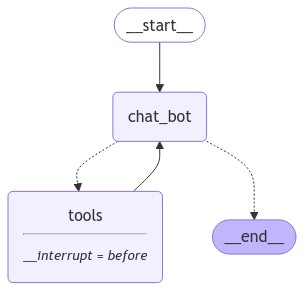

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
input = {"messages":[{"role":"user","content":"what is Langgraph"}]}

thread_config = {"configurable":{"thread_id":"1"}}

for event in app.stream(input=input,config=thread_config,stream_mode="values"):
  # print(event)
  event['messages'][-1].pretty_print()

================================ Human Message =================================

what is Langgraph
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (f6833e1f-72ee-497e-ad74-89c2c11dfc0f)
 Call ID: f6833e1f-72ee-497e-ad74-89c2c11dfc0f
  Args:
    query: what is Langgraph


In [ ]:
snap_shot = app.get_state(thread_config)
for m in snap_shot.values["messages"]:
  m.pretty_print()

================================ Human Message =================================

what is Langgraph
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (f6833e1f-72ee-497e-ad74-89c2c11dfc0f)
 Call ID: f6833e1f-72ee-497e-ad74-89c2c11dfc0f
  Args:
    query: what is Langgraph


In [ ]:
snap_shot.next

('tools',)

In [ ]:
for event in app.stream(input=None,config=thread_config,stream_mode="values"):
  # print(event)
  event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (f6833e1f-72ee-497e-ad74-89c2c11dfc0f)
 Call ID: f6833e1f-72ee-497e-ad74-89c2c11dfc0f
  Args:
    query: what is Langgraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a framework for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph with examples, integration with LangChain, and streaming support."}, {"url": "https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787", "content": "LangGraph is a low-level framework that offers extensive customisation options, allowing you to build precisely what you need. Since LangGraph is built on top of LangChain, it's seamlessly integrated into its ecosystem, making it easy 

In [ ]:
snap_shot = app.get_state(thread_config)
for m in snap_shot.values["messages"]:
  m.pretty_print()

================================ Human Message =================================

what is Langgraph
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (f6833e1f-72ee-497e-ad74-89c2c11dfc0f)
 Call ID: f6833e1f-72ee-497e-ad74-89c2c11dfc0f
  Args:
    query: what is Langgraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a framework for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph with examples, integration with LangChain, and streaming support."}, {"url": "https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787", "content": "LangGraph is a low-level framework that offers extensive customisation options, allowing you to build precisely what you need. Since La

In [ ]:
snap_shot.next

()

# Mannually Update state